In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import numpy as np
from models.vision import LeNetMnist, weights_init, LeNet
from utils import label_to_onehot, cross_entropy_for_onehot
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import lpips
import os

In [2]:
def mse(gt_data, reconstructed_data):
    return ((gt_data - reconstructed_data) ** 2).mean()

def mse_after_projection(gt_data, reconstructed_data):
    return ((gt_data - torch.clamp(reconstructed_data, min=0, max=1)) ** 2).mean()

def psnr(gt_data, reconstructed_data, max_val=1):
    reconstructed_data = torch.clamp(reconstructed_data, min=0, max=1)
    n = len(gt_data)
    mse_loss = ((gt_data.view(n, -1) - reconstructed_data.view(n, -1)) ** 2).mean(1)
    return (20 * torch.log10(max_val / torch.sqrt(mse_loss))).mean()

loss_fn_vgg = lpips.LPIPS(net='vgg')
def lpips_score(gt_data, reconstructed_data, arr=False):
    if arr:
        return loss_fn_vgg(gt_data, reconstructed_data)
    else:
        return loss_fn_vgg(gt_data, reconstructed_data).mean()
    
tt = transforms.ToPILImage()
def show_examples(gt_imgs, pred_imgs, loss, num=10, bias=6, name="main"):
    rank = torch.argsort(loss)
    best_id_list = rank[:num]
    worst_id_list = rank[-num:]
    torch.manual_seed(0)
    random_id_list = torch.randperm(len(rank))[bias:num+bias]

    fig, axs = plt.subplots(1, num, figsize=(8, 6 * num))
    for j, random_id in enumerate(random_id_list):
        axs[j].imshow(tt(gt_imgs[random_id].view(3, 32, 32).cpu()))
        axs[j].axis('off')
    plt.savefig(f"checkpoint/our_gt_{name}.pdf", bbox_inches='tight')
    
    fig, axs = plt.subplots(1, num, figsize=(8, 6 * num))
    for j, random_id in enumerate(random_id_list):
        axs[j].imshow(tt(pred_imgs[random_id].view(3, 32, 32).cpu()))
        axs[j].axis('off')
    plt.savefig(f"checkpoint/our_our_{name}.pdf", bbox_inches='tight')
    return

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/ecs-user/miniconda3/envs/fed/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ecs-user/miniconda3/envs/fed/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ecs-user/miniconda3/envs/fed/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [3]:
shared_model = "LeNet" 
name = "LeNet_batch1"
seed = 0
lr = 1e-4
epochs = 200
model = "MLP-3000"
batch_size = 256
dataset = "CIFAR10"
leak_mode = None
        
checkpoint_name = f"/home/ecs-user/fgi/checkpoint/CIFAR10_LeNet_efficient_fed_unlearning_0.0001_28_256.pt"
checkpoint = torch.load(checkpoint_name)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ecs-user/miniconda3/envs/fed/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
MSE Loss after Projection: 0.027512745931744576
PSNR Loss: 16.11505699157715
LPIPS Loss: 0.3549940884113312
SSIM Score: 0.3591545522212982


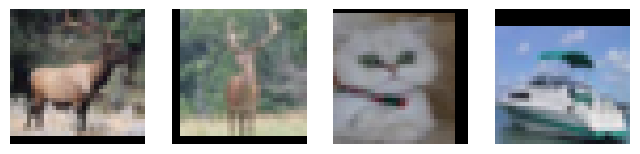

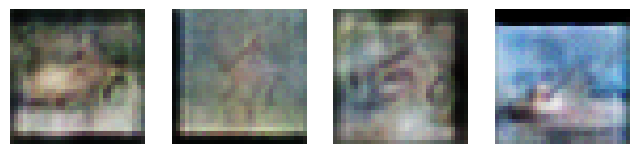

In [4]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import lpips
from torch import nn
from pytorch_msssim import ssim

# Assume checkpoint_name is defined elsewhere
checkpoint = torch.load(checkpoint_name)
reconstructed_data = checkpoint["reconstructed_imgs"].view(-1, 3, 32, 32)
gt_data = checkpoint["gt_data"].view(-1, 3, 32, 32).cpu()

# Define the evaluation functions
def mse(gt_data, reconstructed_data):
    return ((gt_data[:10000] - reconstructed_data) ** 2).mean()

def mse_after_projection(gt_data, reconstructed_data):
    return ((gt_data - torch.clamp(reconstructed_data, min=0, max=1)) ** 2).mean()

def psnr(gt_data, reconstructed_data, max_val=1):
    reconstructed_data = torch.clamp(reconstructed_data, min=0, max=1)
    n = len(gt_data)
    mse_loss = ((gt_data.view(n, -1) - reconstructed_data.view(n, -1)) ** 2).mean(1)
    return (20 * torch.log10(max_val / torch.sqrt(mse_loss))).mean()

# LPIPS loss function initialization
loss_fn_vgg = lpips.LPIPS(net='vgg')

def lpips_score(gt_data, reconstructed_data, arr=False):
    if arr:
        return loss_fn_vgg(gt_data, reconstructed_data)
    else:
        return loss_fn_vgg(gt_data, reconstructed_data).mean()

# SSIM calculation function
def ssim_score(gt_data, reconstructed_data):
    return ssim(gt_data, reconstructed_data, data_range=1.0, size_average=True)

# Convert tensor to PIL image
tt = transforms.ToPILImage()

# Visualization function to display examples
def show_examples(gt_imgs, pred_imgs, loss, num=4, bias=6, name="main"):
    rank = torch.argsort(loss)
    best_id_list = rank[:num]
    worst_id_list = rank[-num:]
    torch.manual_seed(0)
    random_id_list = torch.randperm(len(rank))[bias:num+bias]

    # Show ground truth images
    fig, axs = plt.subplots(1, num, figsize=(8, 6 * num))
    for j, random_id in enumerate(random_id_list):
        axs[j].imshow(tt(gt_imgs[random_id].view(3, 32, 32).cpu()))
        axs[j].axis('off')
    plt.savefig(f"checkpoint/our_gt_{name}.pdf", bbox_inches='tight')
    
    # Show reconstructed images
    fig, axs = plt.subplots(1, num, figsize=(8, 6 * num))
    for j, random_id in enumerate(random_id_list):
        axs[j].imshow(tt(pred_imgs[random_id].view(3, 32, 32).cpu()))
        axs[j].axis('off')
    plt.savefig(f"checkpoint/our_our_{name}.pdf", bbox_inches='tight')
    return

# Calculate MSE, PSNR, LPIPS, SSIM
mse_losses = ((gt_data - reconstructed_data) ** 2).mean((1, 2, 3))
mse_proj_loss = mse_after_projection(gt_data, reconstructed_data)
psnr_loss = psnr(gt_data, reconstructed_data)
lpips_loss = lpips_score(gt_data, reconstructed_data)
ssim_loss = ssim_score(gt_data, reconstructed_data)

# Print results
print(f'MSE Loss after Projection: {mse_proj_loss.item()}')
print(f'PSNR Loss: {psnr_loss.item()}')
print(f'LPIPS Loss: {lpips_loss.item()}')
print(f'SSIM Score: {ssim_loss.item()}')  # SSIM 值越接近1，表示图像越相似

# Evaluate and visualize the best and worst images based on MSE (or any other metric)
loss = mse_losses # You can also use mse_proj_loss, psnr_loss, or lpips_loss based on preference
show_examples(gt_data, reconstructed_data, loss, num=4, bias=0, name="example")


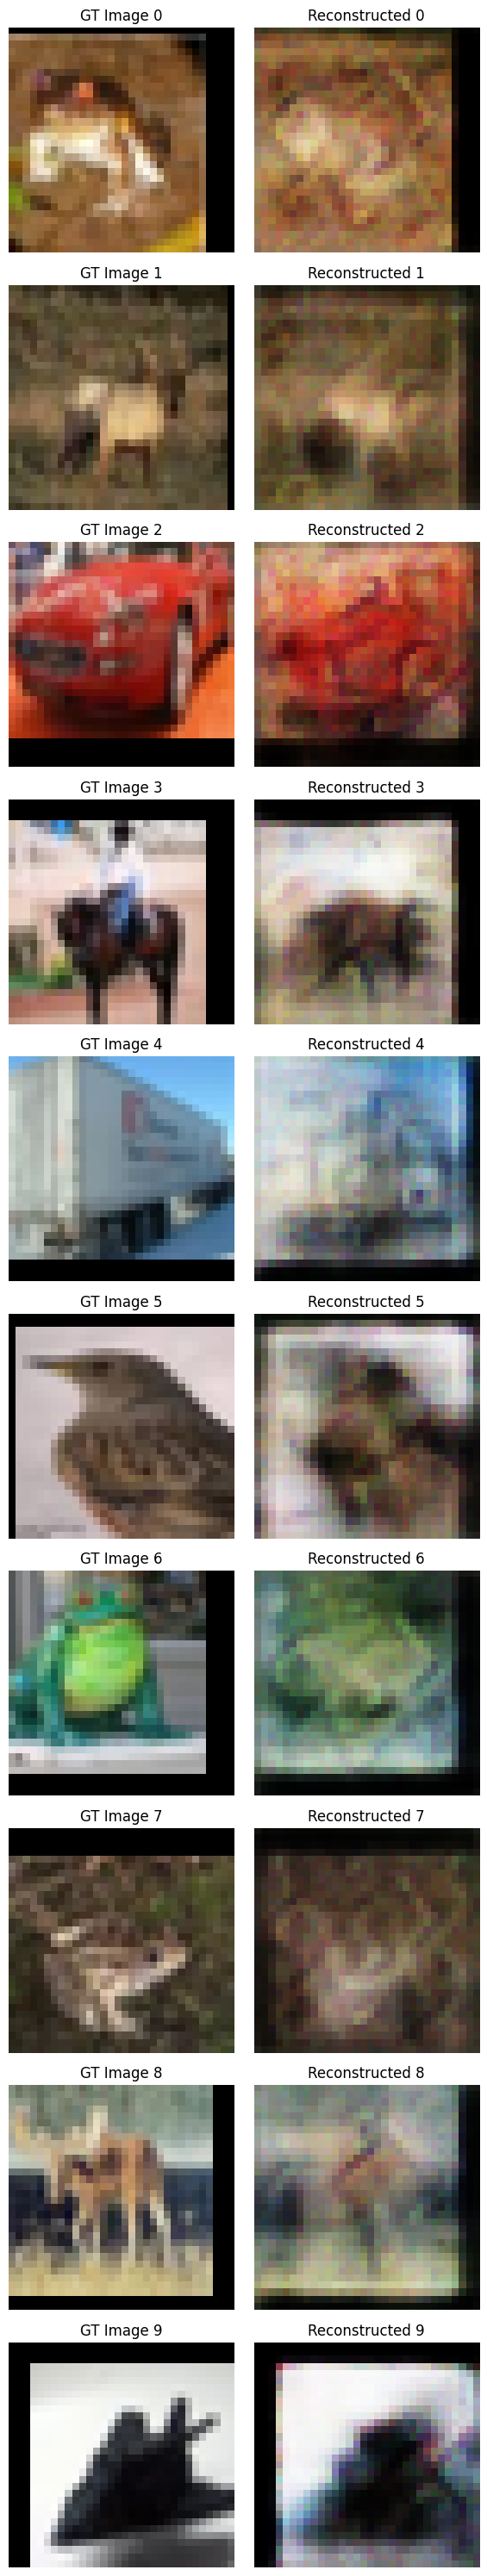

In [5]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# 定义转换函数
tt = transforms.ToPILImage()

# Assume checkpoint_name is defined elsewhere
checkpoint = torch.load(checkpoint_name)
reconstructed_data = checkpoint["reconstructed_imgs"].view(-1, 3, 32, 32)
gt_data = checkpoint["gt_data"].view(-1, 3, 32, 32).cpu()

# 这里假设 gt_data 和 reconstructed_data 已经被正确加载
num_images = min(10, len(gt_data))  # 选择最多显示10张，以免过多

fig, axs = plt.subplots(num_images, 2, figsize=(6, 3 * num_images))

for i in range(num_images):
    # 显示 ground truth 图像
    axs[i, 0].imshow(tt(gt_data[i].cpu()))
    axs[i, 0].set_title(f"GT Image {i}")
    axs[i, 0].axis('off')

    # 显示 reconstructed 图像
    axs[i, 1].imshow(tt(reconstructed_data[i].cpu()))
    axs[i, 1].set_title(f"Reconstructed {i}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


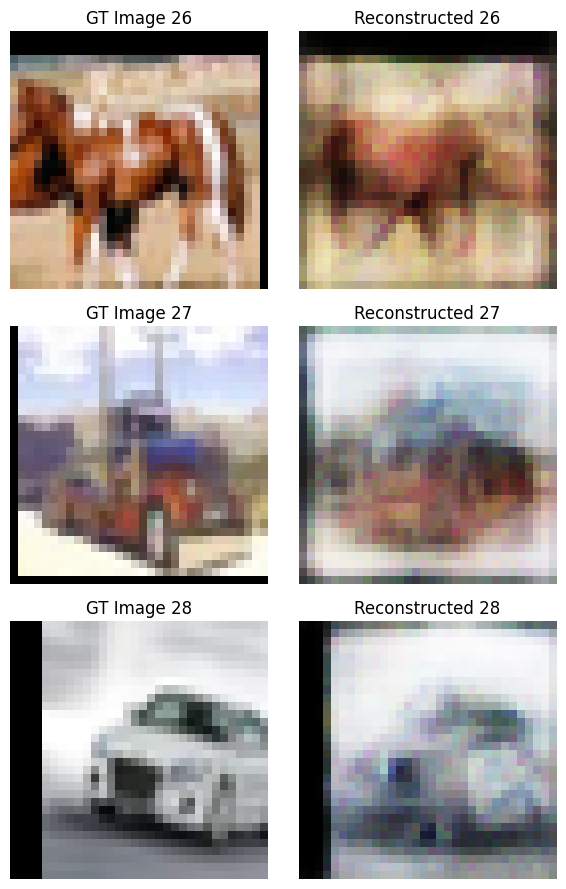

In [15]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# 定义转换函数
tt = transforms.ToPILImage()

def visualize_images(gt_data, reconstructed_data, indices=None):
    """
    可视化指定的 ground truth 和 reconstructed 图像。
    
    参数:
    - gt_data: Ground truth 数据张量，形状为 [N, 3, 32, 32]
    - reconstructed_data: 重建数据张量，形状为 [N, 3, 32, 32]
    - indices: 要显示的图像索引列表（可选），默认为前10张
    """
    # 如果未提供 indices，默认显示前10张（或数据中的最小数量）
    if indices is None:
        num_images = min(10, len(gt_data))
        indices = list(range(num_images))
    else:
        # 确保 indices 不超过数据范围
        indices = [i for i in indices if i < len(gt_data)]
        num_images = len(indices)

    if num_images == 0:
        print("No valid indices provided.")
        return

    # 创建画布
    fig, axs = plt.subplots(num_images, 2, figsize=(6, 3 * num_images))

    # 如果只有一张图像，axs 不是二维数组，需调整
    if num_images == 1:
        axs = axs.reshape(1, -1)

    for idx, i in enumerate(indices):
        # 显示 ground truth 图像
        axs[idx, 0].imshow(tt(gt_data[i].cpu()))
        axs[idx, 0].set_title(f"GT Image {i}")
        axs[idx, 0].axis('off')

        # 显示 reconstructed 图像
        axs[idx, 1].imshow(tt(reconstructed_data[i].cpu()))
        axs[idx, 1].set_title(f"Reconstructed {i}")
        axs[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

# 加载数据（假设 checkpoint_name 已定义）
checkpoint = torch.load(checkpoint_name)
reconstructed_data = checkpoint["reconstructed_imgs"].view(-1, 3, 32, 32)
gt_data = checkpoint["gt_data"].view(-1, 3, 32, 32).cpu()

# 示例用法
# 默认显示前10张
# visualize_images(gt_data, reconstructed_data)

# # 指定显示特定索引的图像，例如第 5、10、15 张
visualize_images(gt_data, reconstructed_data, indices=[26, 27, 28])

# 显示第 0 到第 4 张
# visualize_images(gt_data, reconstructed_data, indices=[0, 1, 2, 3, 4])

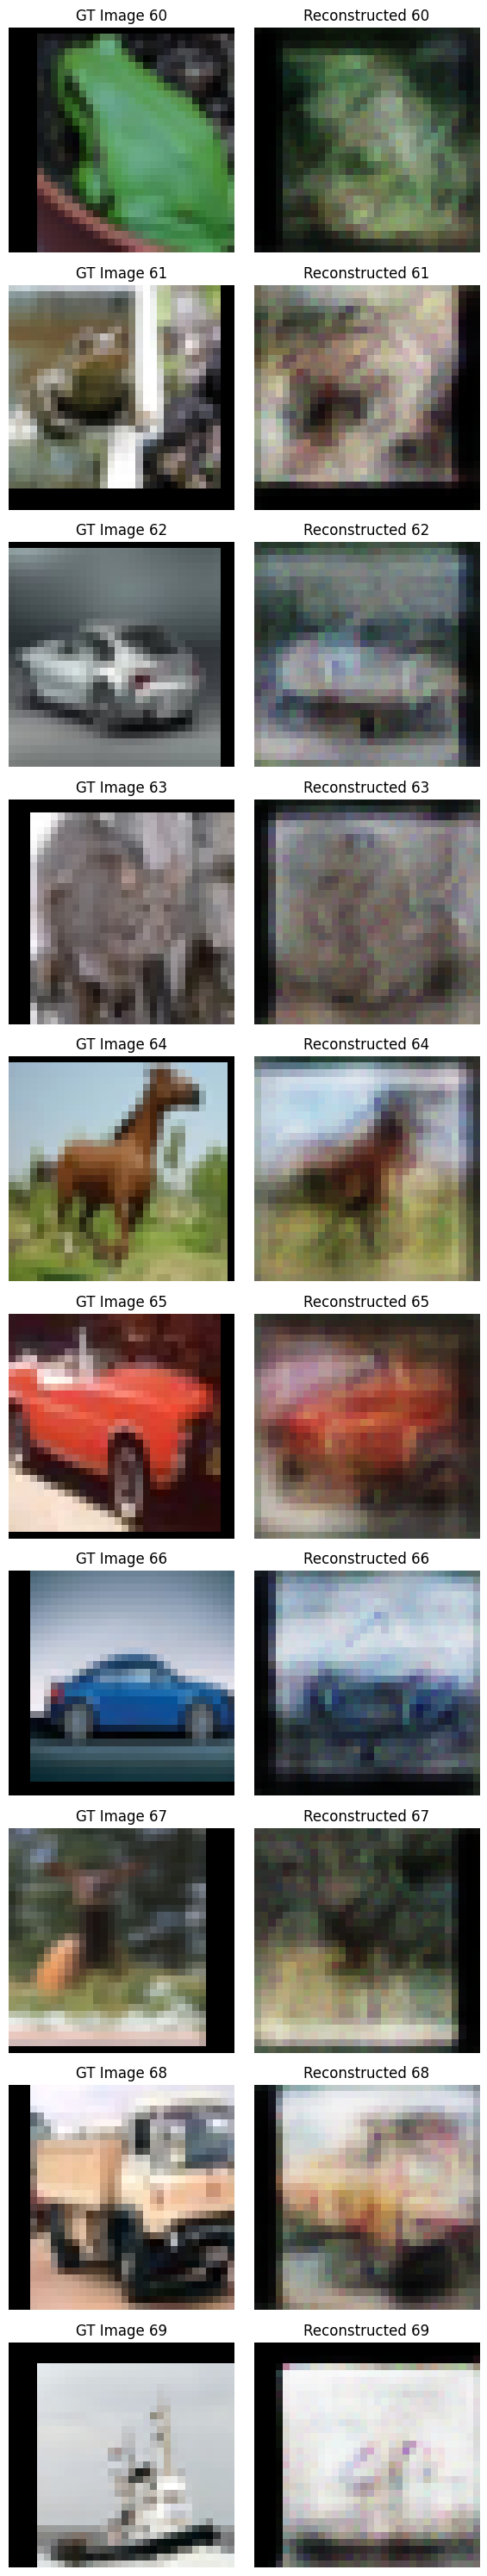

In [17]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# 定义转换函数
tt = transforms.ToPILImage()

def visualize_image_ranges(gt_data, reconstructed_data, ranges=None):
    """
    可视化指定范围内的 ground truth 和 reconstructed 图像。
    
    参数:
    - gt_data: Ground truth 数据张量，形状为 [N, 3, 32, 32]
    - reconstructed_data: 重建数据张量，形状为 [N, 3, 32, 32]
    - ranges: 要显示的图像索引范围列表，例如 [(10, 20), (25, 30)]，默认为前10张
    """
    # 如果未提供 ranges，默认显示前10张
    if ranges is None:
        num_images = min(10, len(gt_data))
        indices = list(range(num_images))
    else:
        # 将所有范围内的索引合并
        indices = []
        for start, end in ranges:
            # 确保范围有效
            start = max(0, start)
            end = min(len(gt_data), end)
            if start < end:
                indices.extend(range(start, end))
        
        num_images = len(indices)
        if num_images == 0:
            print("No valid indices in the provided ranges.")
            return

    # 创建画布
    fig, axs = plt.subplots(num_images, 2, figsize=(6, 3 * num_images))

    # 如果只有一张图像，调整 axs 形状
    if num_images == 1:
        axs = axs.reshape(1, -1)

    for idx, i in enumerate(indices):
        # 显示 ground truth 图像
        axs[idx, 0].imshow(tt(gt_data[i].cpu()))
        axs[idx, 0].set_title(f"GT Image {i}")
        axs[idx, 0].axis('off')

        # 显示 reconstructed 图像
        axs[idx, 1].imshow(tt(reconstructed_data[i].cpu()))
        axs[idx, 1].set_title(f"Reconstructed {i}")
        axs[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

# 加载数据（假设 checkpoint_name 已定义）
checkpoint = torch.load(checkpoint_name)
reconstructed_data = checkpoint["reconstructed_imgs"].view(-1, 3, 32, 32)
gt_data = checkpoint["gt_data"].view(-1, 3, 32, 32).cpu()

# 示例用法
# 默认显示前10张
# visualize_image_ranges(gt_data, reconstructed_data)

# 显示 10-20 范围内的图像
visualize_image_ranges(gt_data, reconstructed_data, ranges=[(60, 70)])

# 显示 10-20 和 25-30 范围内的图像
# visualize_image_ranges(gt_data, reconstructed_data, ranges=[(10, 20), (25, 30)])

# 显示 0-5 和 15-25 范围内的图像

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ecs-user/miniconda3/envs/fed/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


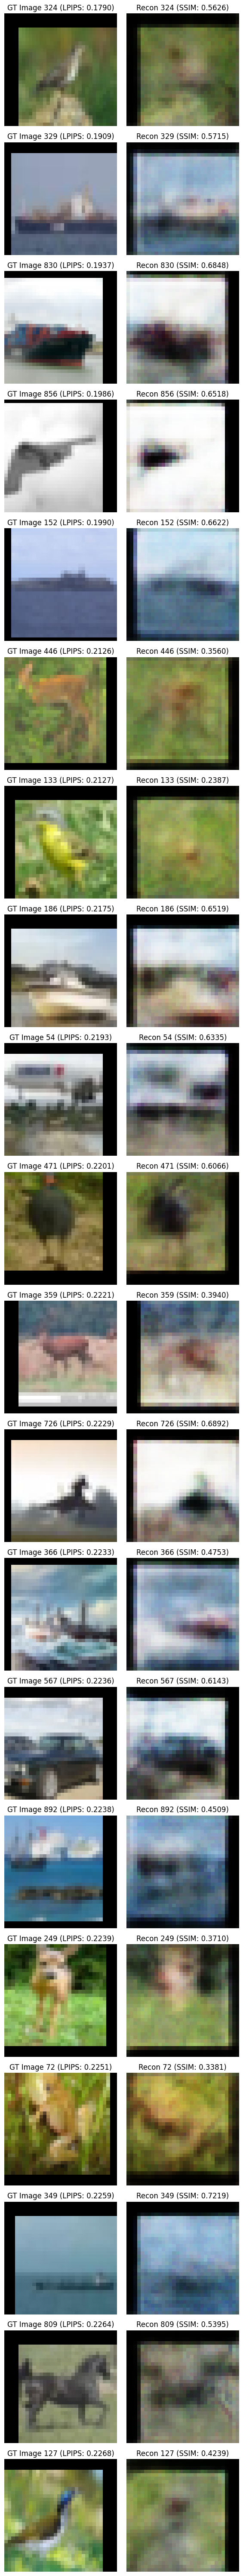

Selected images:
Index 324: LPIPS = 0.1790, SSIM = 0.5626
Index 329: LPIPS = 0.1909, SSIM = 0.5715
Index 830: LPIPS = 0.1937, SSIM = 0.6848
Index 856: LPIPS = 0.1986, SSIM = 0.6518
Index 152: LPIPS = 0.1990, SSIM = 0.6622
Index 446: LPIPS = 0.2126, SSIM = 0.3560
Index 133: LPIPS = 0.2127, SSIM = 0.2387
Index 186: LPIPS = 0.2175, SSIM = 0.6519
Index 54: LPIPS = 0.2193, SSIM = 0.6335
Index 471: LPIPS = 0.2201, SSIM = 0.6066
Index 359: LPIPS = 0.2221, SSIM = 0.3940
Index 726: LPIPS = 0.2229, SSIM = 0.6892
Index 366: LPIPS = 0.2233, SSIM = 0.4753
Index 567: LPIPS = 0.2236, SSIM = 0.6143
Index 892: LPIPS = 0.2238, SSIM = 0.4509
Index 249: LPIPS = 0.2239, SSIM = 0.3710
Index 72: LPIPS = 0.2251, SSIM = 0.3381
Index 349: LPIPS = 0.2259, SSIM = 0.7219
Index 809: LPIPS = 0.2264, SSIM = 0.5395
Index 127: LPIPS = 0.2268, SSIM = 0.4239


In [9]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import lpips
from pytorch_msssim import ssim

# 定义转换函数
tt = transforms.ToPILImage()

def compute_lpips_ssim(gt_data, reconstructed_data):
    """
    计算每张图像的 LPIPS 和 SSIM 值。
    
    参数:
    - gt_data: Ground truth 数据张量，形状为 [N, 3, 32, 32]
    - reconstructed_data: 重建数据张量，形状为 [N, 3, 32, 32]
    
    返回:
    - lpips_values: 每张图像的 LPIPS 值
    - ssim_values: 每张图像的 SSIM 值
    """
    loss_fn_vgg = lpips.LPIPS(net='vgg').to('cuda')
    gt_data = gt_data.to('cuda')
    reconstructed_data = reconstructed_data.to('cuda')
    
    num_images = len(gt_data)
    lpips_values = torch.zeros(num_images).to('cuda')
    ssim_values = torch.zeros(num_images).to('cuda')
    
    # 批量计算 LPIPS 和 SSIM
    for i in range(num_images):
        gt_img = gt_data[i].unsqueeze(0)  # [1, 3, 32, 32]
        recon_img = reconstructed_data[i].unsqueeze(0)  # [1, 3, 32, 32]
        
        # LPIPS 需要 [-1, 1] 范围
        gt_img_lpips = gt_img * 2 - 1
        recon_img_lpips = recon_img * 2 - 1
        lpips_values[i] = loss_fn_vgg(gt_img_lpips, recon_img_lpips).item()
        
        # SSIM 需要 [0, 1] 范围
        ssim_values[i] = ssim(gt_img, recon_img, data_range=1.0, size_average=True).item()
    
    return lpips_values.cpu(), ssim_values.cpu()

def visualize_best_images(gt_data, reconstructed_data, num_display=5):
    """
    可视化 LPIPS 值最小和 SSIM 值最大的图像。
    
    参数:
    - gt_data: Ground truth 数据张量，形状为 [N, 3, 32, 32]
    - reconstructed_data: 重建数据张量，形状为 [N, 3, 32, 32]
    - num_display: 显示的图像数量
    """
    # 计算 LPIPS 和 SSIM
    lpips_values, ssim_values = compute_lpips_ssim(gt_data, reconstructed_data)
    
    # 根据 LPIPS 升序和 SSIM 降序排序
    lpips_indices = torch.argsort(lpips_values)  # LPIPS 最小
    ssim_indices = torch.argsort(ssim_values, descending=True)  # SSIM 最大
    
    # 选择最佳图像索引
    selected_indices = []
    seen = set()
    
    # 优先选择 LPIPS 最小的图像
    for idx in lpips_indices:
        if idx.item() not in seen and len(selected_indices) < num_display:
            selected_indices.append(idx.item())
            seen.add(idx.item())
    
    # 如果数量不足，再从 SSIM 最大的图像中补充
    for idx in ssim_indices:
        if idx.item() not in seen and len(selected_indices) < num_display:
            selected_indices.append(idx.item())
            seen.add(idx.item())
    
    num_images = len(selected_indices)
    if num_images == 0:
        print("No images to display.")
        return
    
    # 创建画布
    fig, axs = plt.subplots(num_images, 2, figsize=(6, 3 * num_images))
    if num_images == 1:
        axs = axs.reshape(1, -1)
    
    for idx, i in enumerate(selected_indices):
        # 显示 ground truth 图像
        axs[idx, 0].imshow(tt(gt_data[i].cpu()))
        axs[idx, 0].set_title(f"GT Image {i} (LPIPS: {lpips_values[i]:.4f})")
        axs[idx, 0].axis('off')

        # 显示 reconstructed 图像
        axs[idx, 1].imshow(tt(reconstructed_data[i].cpu()))
        axs[idx, 1].set_title(f"Recon {i} (SSIM: {ssim_values[i]:.4f})")
        axs[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 打印选择的图像索引和对应值
    print("Selected images:")
    for i in selected_indices:
        print(f"Index {i}: LPIPS = {lpips_values[i]:.4f}, SSIM = {ssim_values[i]:.4f}")

# 加载数据（假设 checkpoint_name 已定义）
checkpoint = torch.load(checkpoint_name)
reconstructed_data = checkpoint["reconstructed_imgs"].view(-1, 3, 32, 32)
gt_data = checkpoint["gt_data"].view(-1, 3, 32, 32).cpu()

# 显示 LPIPS 最小和 SSIM 最大的前5张图像
visualize_best_images(gt_data, reconstructed_data, num_display=20)